In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

#df = pd.read_csv('Telco-Customer-Churn.csv')
df = pd.read_csv('https://raw.githubusercontent.com/cvii-d/telco_churn/refs/heads/main/Telco-Customer-Churn.csv')
# Display the updated DataFrame
print(df.head())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [70]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

# Check for data types of each column
data_types = df.dtypes
print("\nData Types:")
print(data_types)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicate_rows}")

# Check for outliers in numeric columns using basic statistics
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
outliers = {}



Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod       

for col in numeric_columns:
    col_stats = {
        'min': df[col].min(),
        'max': df[col].max(),
        'mean': df[col].mean(),
        'std_dev': df[col].std(),
        'q1': df[col].quantile(0.25),
        'q3': df[col].quantile(0.75),
        'iqr': df[col].quantile(0.75) - df[col].quantile(0.25)
    }
    outliers[col] = col_stats

print("\nOutliers in Numeric Columns:")
for col, stats in outliers.items():
    print(f"{col}:")
    print(stats)
    print(f"Outlier Threshold: Q1 - 1.5*IQR = {stats['q1'] - 1.5*stats['iqr']}, Q3 + 1.5*IQR = {stats['q3'] + 1.5*stats['iqr']}")
    print()

In [71]:
#Convert the TotalCharges to float
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: x.replace('$', '').replace(',', ''))
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Filter churned and stayed customers
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
churned_customers = df[df['Churn'] == 1]
stayed_customers = df[df['Churn'] == 0]

# Check the data types of TotalCharges and MonthlyCharges
#print(df[['TotalCharges', 'MonthlyCharges']].dtypes)


# Calculate medians for churned customers
median_churned = {
    'Median TotalCharges': churned_customers['TotalCharges'].median(),
    'Median MonthlyCharges': churned_customers['MonthlyCharges'].median()
}

# Calculate medians for stayed customers
median_stayed = {
    'Median TotalCharges': stayed_customers['TotalCharges'].median(),
    'Median MonthlyCharges': stayed_customers['MonthlyCharges'].median()
}

print("Median for Churned Customers:", median_churned)
print("Median for Stayed Customers:", median_stayed)

Median for Churned Customers: {'Median TotalCharges': 703.55, 'Median MonthlyCharges': 79.65}
Median for Stayed Customers: {'Median TotalCharges': 1683.6, 'Median MonthlyCharges': 64.42500000000001}


In [72]:
# Features to analyze
features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Calculate the percentage of customers who have used each feature
feature_usage = {}
for feature in features:
    feature_usage[feature] = (df[feature].value_counts(normalize=True) * 100).to_dict()

print("Feature Usage:")
print(feature_usage)

Feature Usage:
{'PhoneService': {'Yes': 90.31662643759762, 'No': 9.683373562402386}, 'MultipleLines': {'No': 48.13289791282124, 'Yes': 42.18372852477638, 'No phone service': 9.683373562402386}, 'InternetService': {'Fiber optic': 43.958540394718156, 'DSL': 34.37455629703251, 'No': 21.666903308249324}, 'OnlineSecurity': {'No': 49.666335368450945, 'Yes': 28.666761323299728, 'No internet service': 21.666903308249324}, 'DeviceProtection': {'No': 43.944341899758626, 'Yes': 34.38875479199205, 'No internet service': 21.666903308249324}, 'TechSupport': {'No': 49.31137299446259, 'Yes': 29.02172369728809, 'No internet service': 21.666903308249324}, 'StreamingTV': {'No': 39.89777083629135, 'Yes': 38.435325855459325, 'No internet service': 21.666903308249324}, 'StreamingMovies': {'No': 39.542808462303, 'Yes': 38.790288229447675, 'No internet service': 21.666903308249324}}


In [73]:
# Calculate the churn status for customers who used each feature

churn_status = {}

for feature in features:
    churned = df[df['Churn'] == 'Yes'][feature].value_counts(normalize=True) * 100
    active = df[df['Churn'] == 'No'][feature].value_counts(normalize=True) * 100
    churn_status[feature] = {
        'Churned': churned.to_dict(),
        'Active': active.to_dict()
    }

#print("\nChurn Status by Feature:")
#print(churn_status)

print("\nChurn Status by Feature (Percentage of Usage):\n")
for feature, status in churn_status.items():
    print(f"Feature: {feature}")
    print("  - Churned:")
    for usage, percentage in status['Churned'].items():
        print(f"      {usage}: {percentage:.2f}%")
    print("  - Active:")
    for usage, percentage in status['Active'].items():
        print(f"      {usage}: {percentage:.2f}%")
    print("\n")



Churn Status by Feature (Percentage of Usage):

Feature: PhoneService
  - Churned:
  - Active:


Feature: MultipleLines
  - Churned:
  - Active:


Feature: InternetService
  - Churned:
  - Active:


Feature: OnlineSecurity
  - Churned:
  - Active:


Feature: DeviceProtection
  - Churned:
  - Active:


Feature: TechSupport
  - Churned:
  - Active:


Feature: StreamingTV
  - Churned:
  - Active:


Feature: StreamingMovies
  - Churned:
  - Active:




C:\Users\badbu\AppData\Local\Temp\ipykernel_24748\3237377112.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  churned = pd.Series(feature_usage_churned[feature])
C:\Users\badbu\AppData\Local\Temp\ipykernel_24748\3237377112.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stayed = pd.Series(feature_usage_stayed[feature])


IndexError: index 0 is out of bounds for axis 0 with size 0

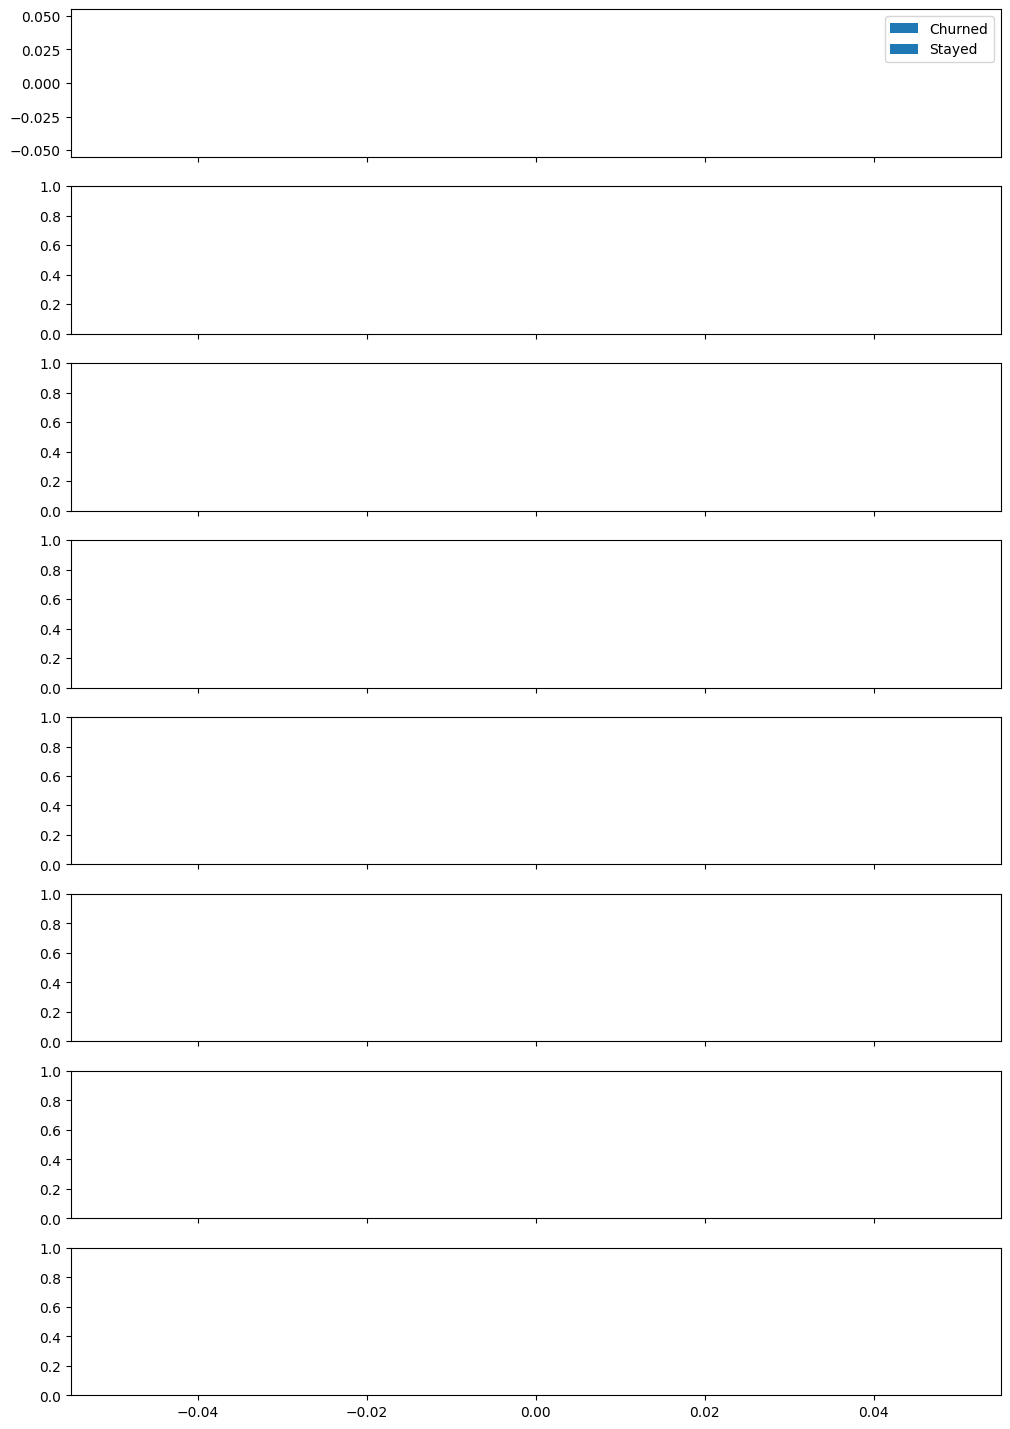

In [74]:
# Calculate feature usage for churned and stayed customers
feature_usage_churned = {}
feature_usage_stayed = {}

for feature in features:
    churned = df[df['Churn'] == "Yes"][feature].value_counts(normalize=True) * 100
    stayed = df[df['Churn'] == "No"][feature].value_counts(normalize=True) * 100

    # Combine churned and stayed data for visualization
    feature_usage_churned[feature] = churned.to_dict()
    feature_usage_stayed[feature] = stayed.to_dict()

# Create bar chart for feature usage
fig, axes = plt.subplots(len(features), 1, figsize=(12, 18), sharex=True)

for i, feature in enumerate(features):
    churned = pd.Series(feature_usage_churned[feature])
    stayed = pd.Series(feature_usage_stayed[feature])

    combined_data = pd.DataFrame({'Churned': churned, 
                                  'Stayed': stayed}).fillna(0)

    ax = axes[i]
    combined_data.plot(kind='barh',
                       ax=ax,
                       color=['indianred', 'lightsteelblue'])
    
    # Add data labels
    for bar in ax.patches:
        width = bar.get_width()
        if width > 0:  # Only label non-zero bars
            ax.text(width + 1, bar.get_y() + bar.get_height() / 2,
                    f'{width:.1f}%', va='center')
    
    ax.set_title(f'Feature Usage: {feature}')
    ax.set_xlabel('% Usage')
    ax.set_ylabel('')

# Add an overarching title
fig.suptitle('Feature Usage by Churn Status (Percentage)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
#plt.savefig('my_plot2.png')
plt.show()

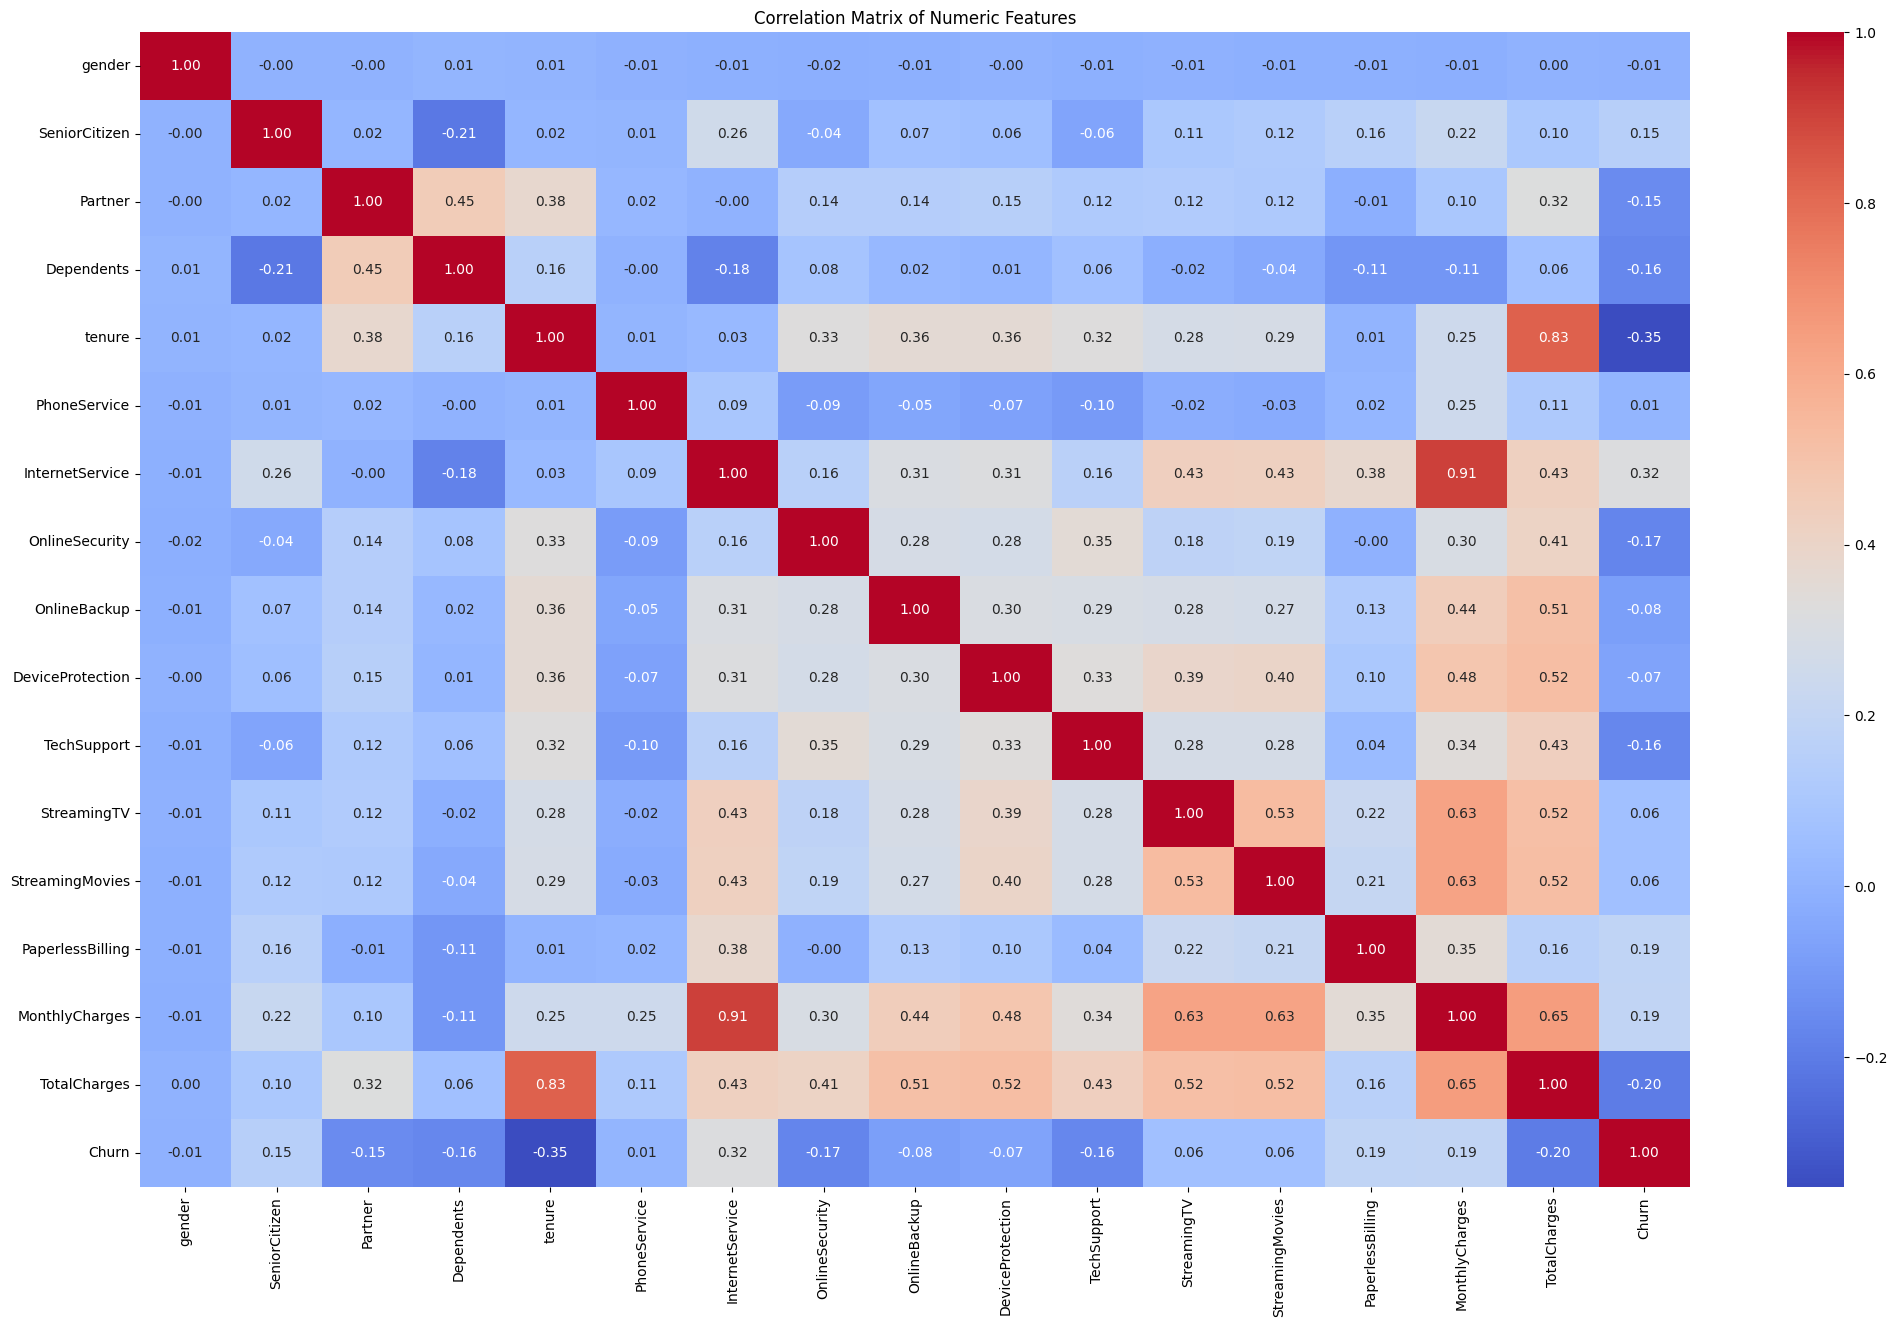

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert 'TotalCharges' to numeric (if it contains non-numeric values)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Encode categorical columns as numeric
binary_columns = ['Churn', 'Partner', 'Dependents', 'PhoneService', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                  'TechSupport', 'StreamingTV', 'StreamingMovies', 
                  'PaperlessBilling']

df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['InternetService'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 2, 'No': 0})

for col in binary_columns:
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

# Select all numeric columns automatically
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Features')
#plt.savefig('my_plot.png')
plt.show()

In [ ]:
# Columns to convert Yes/No values to integers
columns_to_convert = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                      'PaperlessBilling', 'Churn']


# Convert Yes to 1, No to 0
for col in columns_to_convert:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Handle columns with more than Yes/No answers
columns_with_extra_values = ['MultipleLines']
for col in columns_with_extra_values:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No phone service': 2})


# Display the updated DataFrame
print(df.head())

   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG  Female              0        1           0       1   
1  5575-GNVDE    Male              0        0           0      34   
2  3668-QPYBK    Male              0        0           0       2   
3  7795-CFOCW    Male              0        0           0      45   
4  9237-HQITU  Female              0        0           0       2   

   PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0             0              2             DSL             0.0  ...   
1             1              0             DSL             1.0  ...   
2             1              0             DSL             1.0  ...   
3             0              2             DSL             1.0  ...   
4             1              0     Fiber optic             0.0  ...   

  DeviceProtection  TechSupport  StreamingTV  StreamingMovies        Contract  \
0              0.0          0.0          0.0              0.0  Month-to-month

In [ ]:
#Ensure all columns have proper values 
for col in columns_to_convert:
    df[col] = df[col].fillna(0).astype(int)

# Display the updated DataFrame
print(df.head())

column_values = {col: df[col].unique().tolist() for col in df.columns}


# Print the results
for column, values in column_values.items():
    print(f"Column: {column}")
    print(f"Unique Values: {values}")
    print("\n")

   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   
3  7795-CFOCW       1              0        0           0      45   
4  9237-HQITU       0              0        0           0       2   

   PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0             0              2             DSL               0  ...   
1             1              0             DSL               1  ...   
2             1              0             DSL               1  ...   
3             0              2             DSL               1  ...   
4             1              0     Fiber optic               0  ...   

  DeviceProtection  TechSupport  StreamingTV  StreamingMovies        Contract  \
0                0            0            0                0  Month-to-month